In [1]:
# Notre DIP
!git clone https://github.com/quentgar/deep_image_prior.git
!mv deep_image_prior/* ./

!git clone https://github.com/DmitryUlyanov/deep-image-prior
!mv deep-image-prior/* ./

Cloning into 'deep_image_prior'...
remote: Enumerating objects: 68, done.
remote: Counting objects: 100% (68/68), done.
remote: Compressing objects: 100% (50/50), done.
remote: Total 68 (delta 12), reused 4 (delta 1), pack-reused 0
Unpacking objects: 100% (68/68), done.
Cloning into 'deep-image-prior'...
remote: Enumerating objects: 289, done.
remote: Total 289 (delta 0), reused 0 (delta 0), pack-reused 289
Receiving objects: 100% (289/289), 24.28 MiB | 35.68 MiB/s, done.
Resolving deltas: 100% (155/155), done.


In [2]:
pip install voxelmorph

     |████████████████████████████████| 81kB 9.9MB/s 
     |████████████████████████████████| 92kB 12.9MB/s 


In [50]:
from __future__ import print_function
import matplotlib.pyplot as plt
%matplotlib inline

import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '1'

import numpy as np
from models.skip import skip
from src.hourglass_network import *
import torch
import torch.optim

from utils.inpainting_utils import *
from skimage.measure import compare_psnr

from voxelmorph.torch.layers import SpatialTransformer
import seaborn as sns

torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark =True
dtype = torch.cuda.FloatTensor

PLOT = True
imsize = -1
dim_div_by = 32

In [74]:
img1_path = 'mydata/magnet1.jpg'
img2_path = 'mydata/magnet2.jpg'

NET_TYPE = 'skip_depth6' # one of skip_depth4|skip_depth2|UNET|ResNet

In [75]:
img_pil1, img_np1 = get_image(img1_path, imsize)
img_pil2, img_np2 = get_image(img2_path, imsize)

In [76]:
img_pil1 = crop_image(img_pil1, dim_div_by)
img_pil2 = crop_image(img_pil2, dim_div_by)

img_np1 = pil_to_np(img_pil1)
img_np2 = pil_to_np(img_pil2)

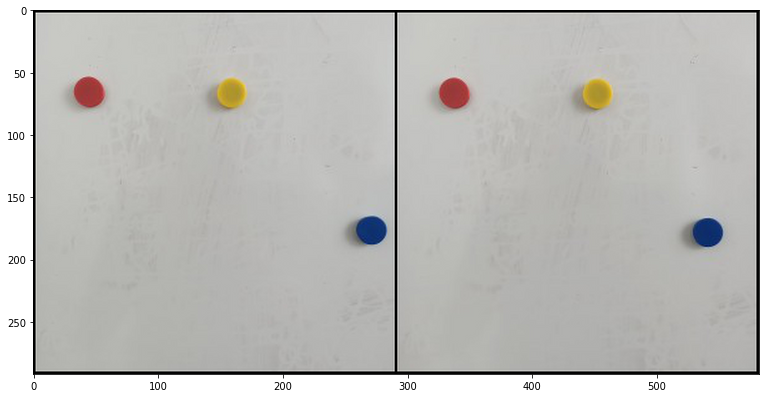

In [77]:
plot_image_grid([img_np1, img_np2], 3,11);

In [78]:
size = img_np1.shape[1:]

In [79]:
pad = 'reflection' # 'zero'
OPT_OVER = 'net'
OPTIMIZER = 'adam'

In [104]:
INPUT = 'noise'
input_depth = 32
LR = 0.01 
num_iter = 600
param_noise = False
show_every = 50
figsize = 5
reg_noise_std = 0.03
depth = 5

net = build_hourglass(input_depth, output_depth=2, 
            num_channels_down = [128]*depth,
            num_channels_up =   [128]*depth,
            num_channels_skip =    [4]*depth,  
            filter_size_up = 3, filter_size_down = 3, 
            up_samp_mode='nearest', filter_skip_size=1,num_scales=depth,need_sigmoid=False).type(dtype)

"""
net = skip(input_depth, img_np.shape[0], 
            num_channels_down = [128] * 5,
            num_channels_up   = [128] * 5,
            num_channels_skip = [0] * 5,  
            upsample_mode='nearest', filter_skip_size=1, filter_size_up=3, filter_size_down=3,
            need_sigmoid=True, need_bias=True, pad=pad, act_fun='LeakyReLU').type(dtype)"""

net = net.type(dtype)
net_input = get_noise(input_depth, INPUT, img_np1.shape[1:]).type(dtype)
#net_input.div_(10)

# Spatial transformer
transformer = SpatialTransformer(size)

In [105]:
# Compute number of parameters
s  = sum(np.prod(list(p.size())) for p in net.parameters())
print ('Number of params: %d' % s)

# Loss
mse = torch.nn.MSELoss().type(dtype)

img_var1 = np_to_torch(img_np1).type(dtype)
img_var2 = np_to_torch(img_np2).type(dtype)

Number of params: 2218086


Starting optimization with ADAM


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.


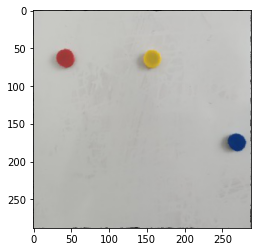

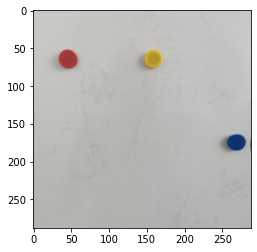

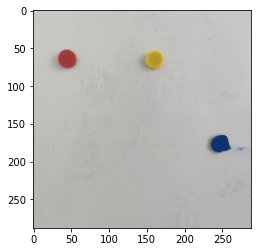

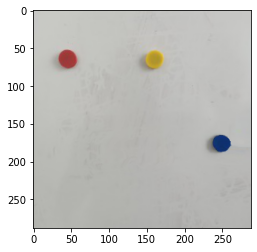

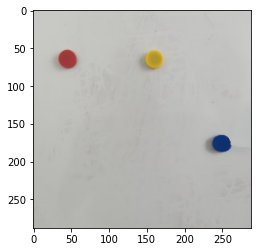

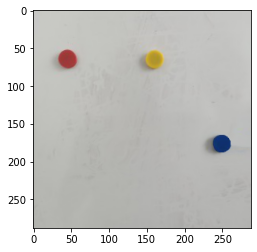

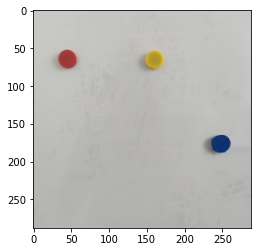

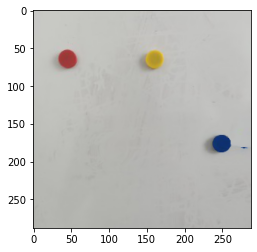

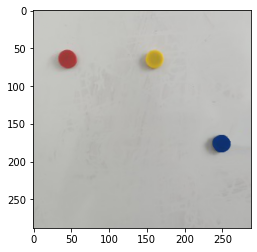

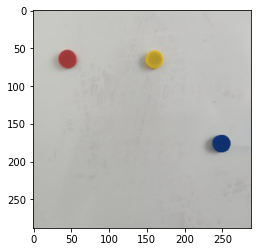

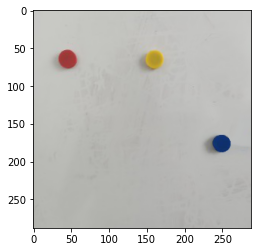

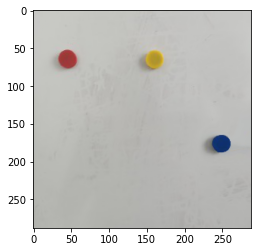

In [106]:
i = 0
list_iter = []
list_psnr = []
list_loss = []
def closure():
    
    global i, list_iter, list_psnr, list_loss
    
    if param_noise:
        for n in [x for x in net.parameters() if len(x.size()) == 4]:
            n = n + n.detach().clone().normal_() * n.std() / 50
    
    net_input = net_input_saved
    if reg_noise_std > 0:
        net_input = net_input_saved + (noise.normal_() * reg_noise_std)
        
        
    out = net(net_input)

    out_trans = transformer(img_var1.type(torch.FloatTensor),out.type(torch.FloatTensor)).type(dtype)
   
    total_loss = mse(out_trans, img_var2)
    total_loss.backward()
        
    if PLOT and i % show_every == 0:
        print ('Iteration %05d    Loss %f' % (i, total_loss.item()), '\r', end='')
        
        out_np = torch_to_np(out_trans)
        list_iter.append(i)
        list_psnr.append(compare_psnr(img_np2,out_np))
        list_loss.append(total_loss.item())
        plt.imshow(out_np.transpose(1,2,0))
        plt.show()
        #plot_image_grid([np.clip(out_np, 0, 1)], factor=figsize, nrow=1)
        
    i += 1

    return total_loss

net_input_saved = net_input.detach().clone()
noise = net_input.detach().clone()

p = get_params(OPT_OVER, net, net_input)
optimize(OPTIMIZER, p, closure, LR, num_iter)

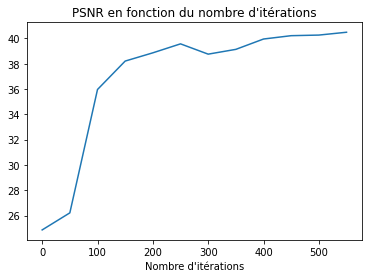

In [107]:
plt.figure()
plt.plot(list_iter,list_psnr,linestyle='-')
plt.title("PSNR en fonction du nombre d'itérations")
plt.xlabel("Nombre d'itérations")
plt.show()

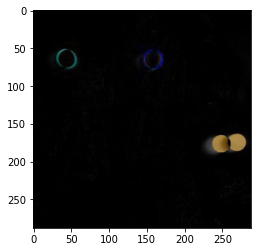

In [108]:
out = net(net_input)
out_trans = transformer(img_var1.type(torch.FloatTensor),out.type(torch.FloatTensor)).type(dtype)
out_np = torch_to_np(out_trans)
t = abs(img_np1 - out_np)
plt.imshow(t.transpose(1,2,0))

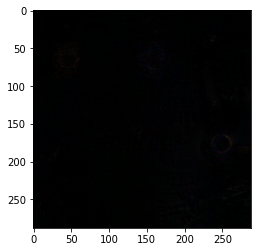

In [109]:
diff = abs(img_np2 - out_np)
plt.imshow(diff.transpose(1,2,0))

In [110]:
v_np = torch_to_np(out)

In [111]:
u = v_np[0]
v = v_np[1]

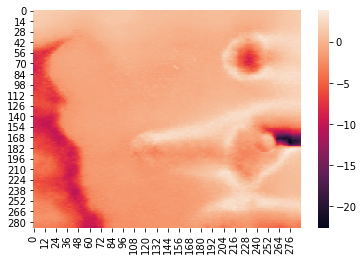

In [112]:
#norme = np.sqrt(u**2 + v**2)
ax = sns.heatmap(u)
plt.show()

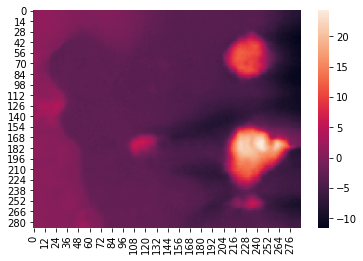

In [113]:
ax = sns.heatmap(v)
plt.show()

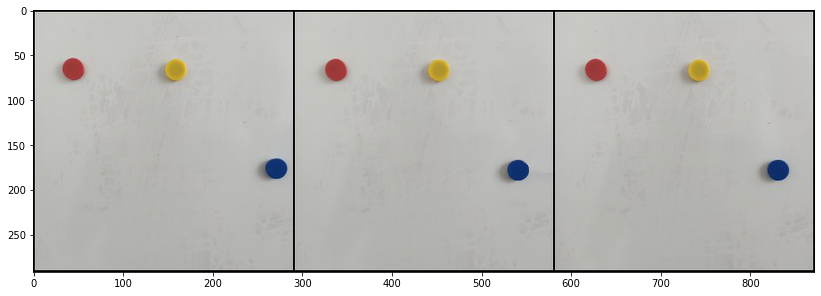

In [114]:
plot_image_grid([img_np1, out_np, img_np2], 3,11);

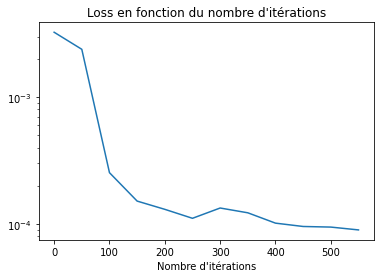

In [115]:
plt.figure()
plt.semilogy(list_iter,list_loss,linestyle='-')
plt.title("Loss en fonction du nombre d'itérations")
plt.xlabel("Nombre d'itérations")
plt.show()

In [ ]:
max(list_psnr)

38.6028760703398

In [ ]:
Ut = best_flow[:,1,:,:]
Vt = best_flow[:,0,:,:]
#print(Ut.shape)
Ut = torch_to_np(Ut)
Vt = torch_to_np(Vt)
#print(Ut.shape)
echant_div = 10
U = Ut[0:size[0]:echant_div, 0:size[1]:echant_div]
V = Vt[0:size[0]:echant_div, 0:size[1]:echant_div]
#print(U.shape)
#print(V.shape)

X, Y = np.meshgrid(np.arange(0, U.shape[1], 1), np.arange(0, U.shape[0], 1))
#print(X.shape)
#print(Y.shape)

x_shape = X.shape

plt.quiver(X,-Y,-U,V, units='xy' ,scale=X.mean()*2, color='red')
plt.show()